In [1]:
import torch
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Importer ZennitCRP
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_path = "data/lizard.jpg"
#image_path = "data/n01843383_180.jpeg"

In [4]:
#image = Image.open(image_path)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

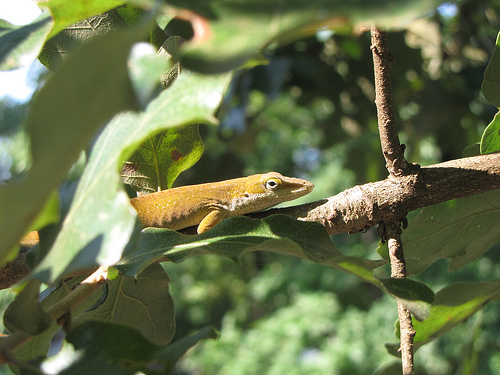

In [5]:
image

In [6]:
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()
print(f"Classe prédite: {pred_class}")
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilités: {probs[0, pred_class]}")

Classe prédite: 40
Probabilités: 0.7104200124740601


In [7]:
data = np.load("data/n01829413_46.npz")

# Afficher les noms des couches enregistrées
print("Couches enregistrées :", list(data.keys()))

Couches enregistrées : ['layer_0', 'layer_3', 'layer_7', 'layer_10', 'layer_14', 'layer_17', 'layer_20', 'layer_24', 'layer_27', 'layer_30', 'layer_34', 'layer_37', 'layer_40']


In [8]:

# Afficher les heatmaps de chaque couche
for key in data.keys():
    print(f"Heatmaps de {key} :")
    print(data[key])  # Affiche la matrice


Heatmaps de layer_0 :
[[[-6.85401390e-19 -1.02663423e-18 -1.00674663e-18 ... -3.04199048e-08
   -4.22471480e-08 -3.31949366e-08]
  [-9.68320476e-19 -1.47950910e-18 -1.51417479e-18 ... -4.43157155e-08
   -5.64345726e-08 -4.27144897e-08]
  [-9.40420604e-19 -1.47942607e-18 -1.50811569e-18 ... -3.75276770e-08
   -4.41352448e-08 -3.20467564e-08]
  ...
  [-1.02463900e-06 -1.48617391e-06 -1.51909137e-06 ... -1.01014822e-10
   -9.63858160e-11 -6.58379115e-11]
  [-1.08181905e-06 -1.60004561e-06 -1.56755709e-06 ... -1.02535980e-10
   -9.55626620e-11 -6.61221702e-11]
  [-7.15975887e-07 -1.09090342e-06 -1.09025223e-06 ... -6.83727450e-11
   -6.42159520e-11 -4.44171470e-11]]

 [[ 5.02251398e-13  7.49073221e-13  7.22555696e-13 ...  4.32717959e-11
    5.87510249e-11  4.59771943e-11]
  [ 7.15430753e-13  1.08796002e-12  1.09509212e-12 ...  6.35123759e-11
    7.90824281e-11  5.95797717e-11]
  [ 7.22184682e-13  1.12942793e-12  1.12797185e-12 ...  5.52421338e-11
    6.38763487e-11  4.63137168e-11]
  ...
 

In [9]:
h1 = data["layer_40"]

In [10]:
print(h1.shape)
print(type(h1))

(512, 224, 224)
<class 'numpy.ndarray'>


In [13]:
import math

def betterPrintHeatmap(heatmaps):
    #heatmaps = [h.detach().cpu().numpy() for h in heatmaps]
    number_line = math.ceil(len(heatmaps) / 5)
    fig, axes = plt.subplots(number_line, 6, figsize=(18, number_line * 2))

    vmin = min(h.min() for h in heatmaps)
    vmax = max(h.max() for h in heatmaps)
    print(f"Min value for a pixel: {vmin}, Max value for a pixel: {vmax}")
    heatmap_element = 0
    for i, ax in enumerate(axes.flat):
        row, col = divmod(i, 6)
        if heatmap_element >= len(heatmaps):
            ax.axis("off")
            continue
        if col > 4:
            ax.axis("off")
            continue
        im = ax.imshow(heatmaps[heatmap_element], cmap="seismic", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(f"Heatmap {heatmap_element+1}")
        heatmap_element += 1


    # Ajouter une barre de couleur verticale à droite de la grille
    fig.colorbar(im, ax=axes, orientation='vertical', location='right')

    # Ajuster l'espacement pour que les heatmaps ne se chevauchent pas
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Afficher la grille
    plt.show()

In [12]:
betterPrintHeatmap(h1)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002A87D289C10> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002A82DFBE700> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [14]:
heatmaps_flat = h1.reshape(h1.shape[0], -1)  # Shape: (512, 50176)

In [15]:
print(heatmaps_flat.shape)

(512, 50176)


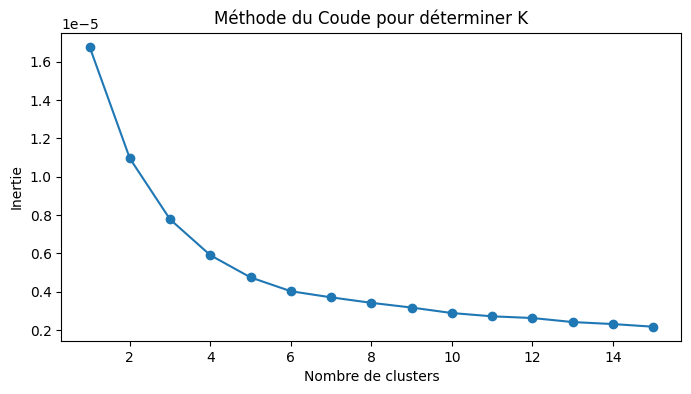

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_k=15):
    """Utilise la méthode du coude pour trouver le nombre optimal de clusters."""
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)  # Somme des distances intra-cluster

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), inertias, marker="o")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Inertie")
    plt.title("Méthode du Coude pour déterminer K")
    plt.show()

find_optimal_clusters(heatmaps_flat)


In [23]:
from sklearn.metrics import silhouette_score

def find_best_silhouette(data, max_k=15):
    """Utilise le score de silhouette pour trouver le nombre optimal de clusters."""
    best_k = 2
    best_score = -1
    scores = []

    for k in range(2, max_k + 1):  # On commence à 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append(score)

        if score > best_score:
            best_k = k
            best_score = score

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k + 1), scores, marker="o")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Score de silhouette pour déterminer K")
    plt.show()

    print(f"Nombre optimal de clusters selon silhouette score : {best_k}")
    return best_k

best_k = find_best_silhouette(heatmaps_flat)

# Clustering avec le bon K trouvé
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(heatmaps_flat)


KeyboardInterrupt: 

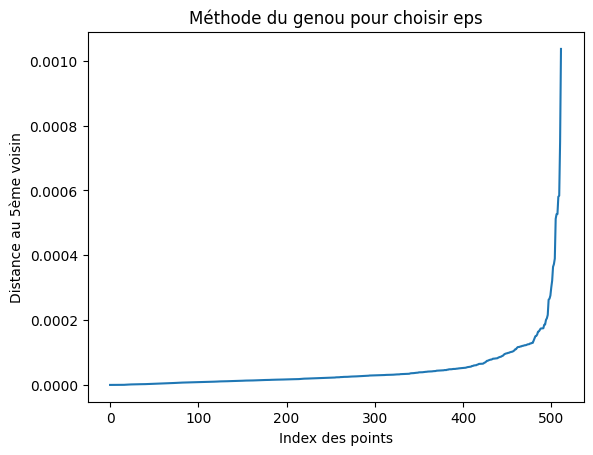

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Trouver le bon eps avec la méthode du genou (knee method)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(heatmaps_flat)
distances, indices = neighbors_fit.kneighbors(heatmaps_flat)

# Trier et tracer les distances des 5 plus proches voisins
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel("Index des points")
plt.ylabel("Distance au 5ème voisin")
plt.title("Méthode du genou pour choisir eps")
plt.show()


In [26]:
from sklearn.cluster import DBSCAN

# Appliquer DBSCAN (ajuste eps et min_samples selon tes données)
dbscan = DBSCAN(eps=0.0001, min_samples=5)  # Ajuster "eps" si les clusters sont trop grands/petits
clusters = dbscan.fit_predict(heatmaps_flat)

# Affichage du nombre de clusters détectés
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1 = bruit
print(f"DBSCAN a détecté {n_clusters} clusters.")


DBSCAN a détecté 1 clusters.


In [27]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculer la distance moyenne entre les heatmaps
dist_matrix = pairwise_distances(heatmaps_flat, metric="euclidean")
mean_dist = np.mean(dist_matrix)

print(f"Distance moyenne entre les heatmaps : {mean_dist}")


Distance moyenne entre les heatmaps : 0.00015177938621491194


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

dbscan = DBSCAN(eps=0.5, min_samples=5)  # Remonte eps
clusters = dbscan.fit_predict(heatmaps_scaled)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")


DBSCAN a détecté 1 clusters après normalisation.


In [34]:
dbscan = DBSCAN(eps=0.2, min_samples=1, metric="cosine")
clusters = dbscan.fit_predict(heatmaps_flat)
print(f"DBSCAN avec distance cosinus a trouvé {len(set(clusters)) - (1 if -1 in clusters else 0)} clusters.")


DBSCAN avec distance cosinus a trouvé 87 clusters.


In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10  # À ajuster selon tes besoins

# Appliquer K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(heatmaps_flat)

print("Attribution des clusters :", clusters)

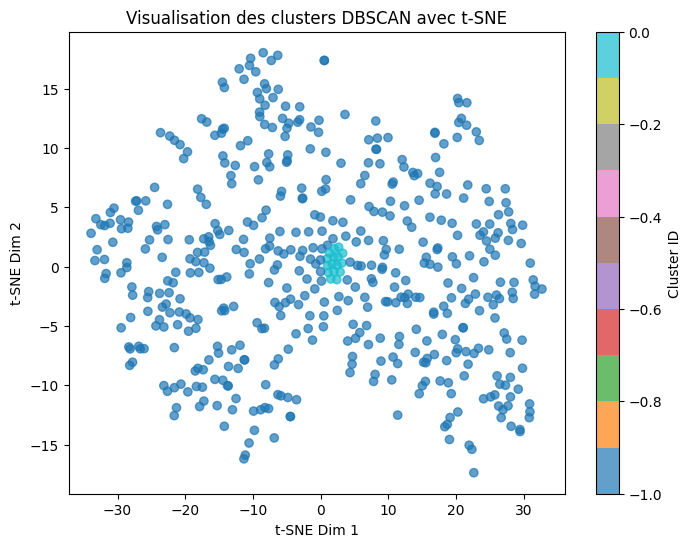

DBSCAN a détecté 1 clusters.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Appliquer DBSCAN avec une meilleure normalisation
dbscan = DBSCAN(eps=0.5, min_samples=5, metric="euclidean")
clusters = dbscan.fit_predict(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], c=clusters, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()

# Afficher le nombre de clusters détectés
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"DBSCAN a détecté {n_clusters} clusters.")

C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\1130336002.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


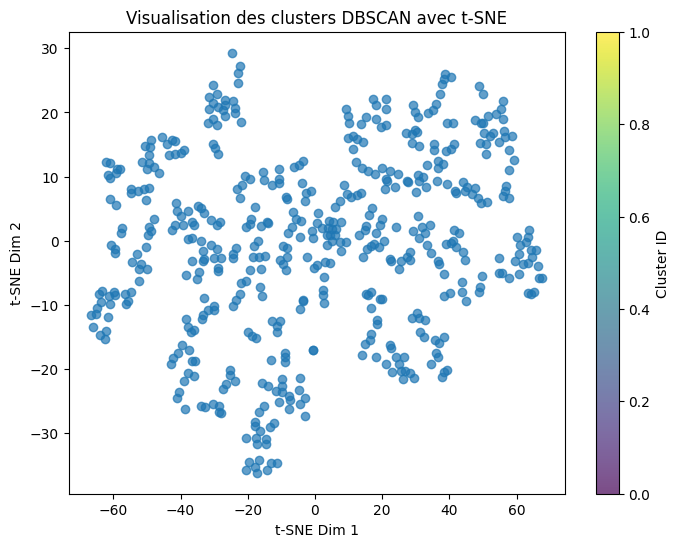

NameError: name 'clusters' is not defined

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()

# Afficher le nombre de clusters détectés
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"DBSCAN a détecté {n_clusters} clusters.")

C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\144229443.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


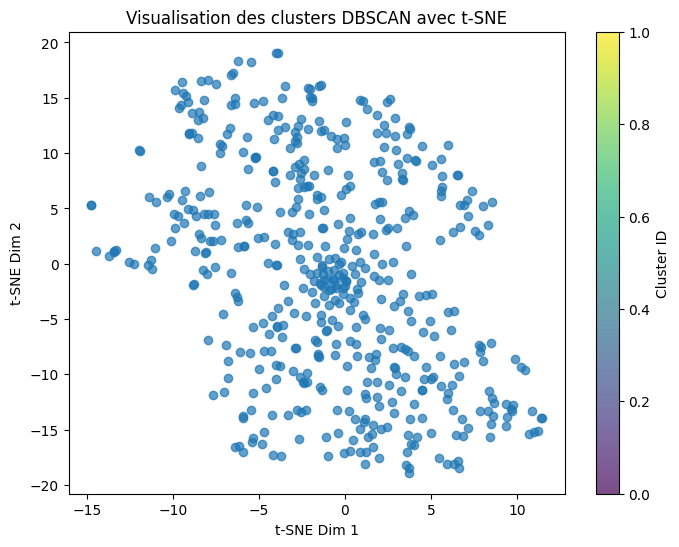

NameError: name 'clusters' is not defined

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()

# Afficher le nombre de clusters détectés
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"DBSCAN a détecté {n_clusters} clusters.")

C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\3649899165.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


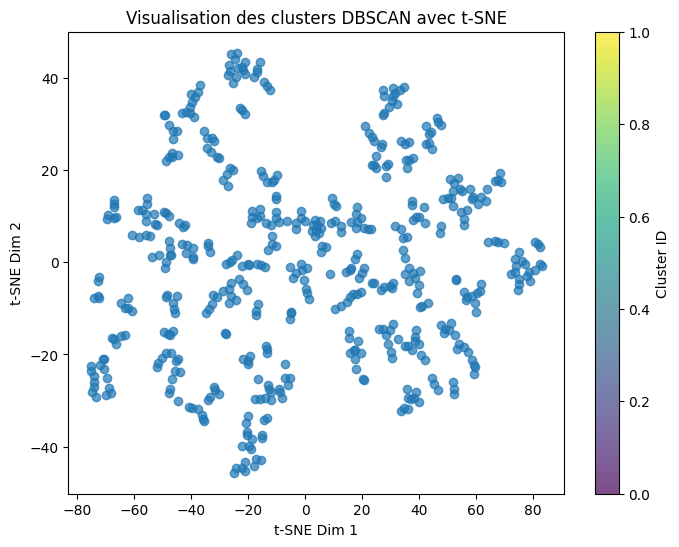

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\3052703593.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


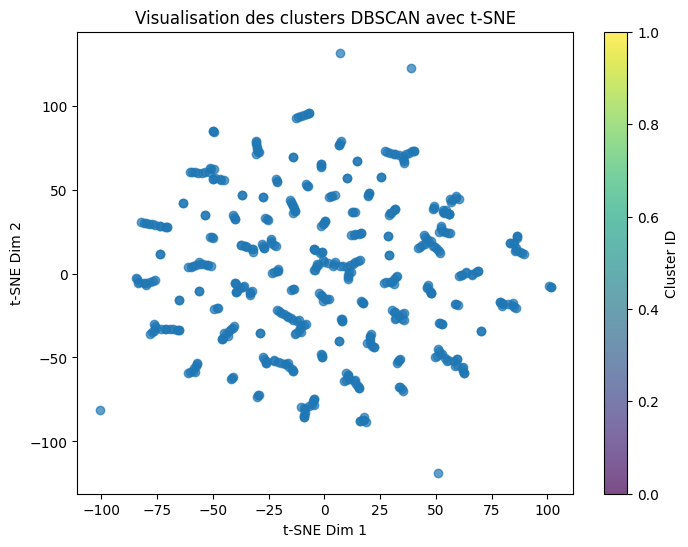

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\2531726567.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


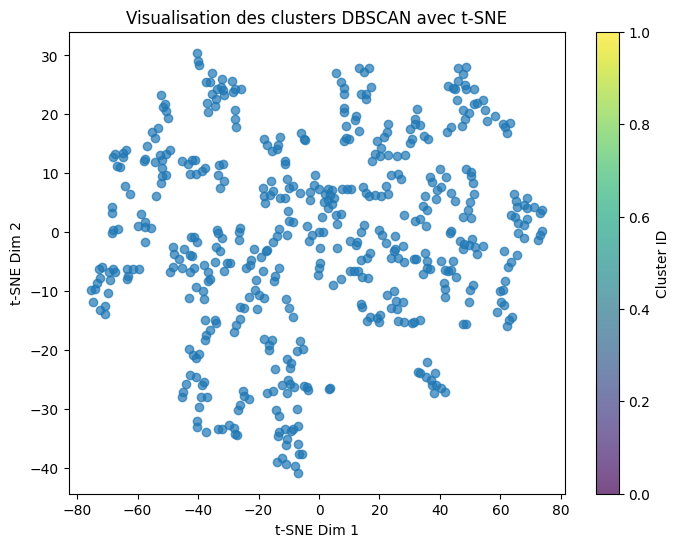

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=8, random_state=42)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\1352728423.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


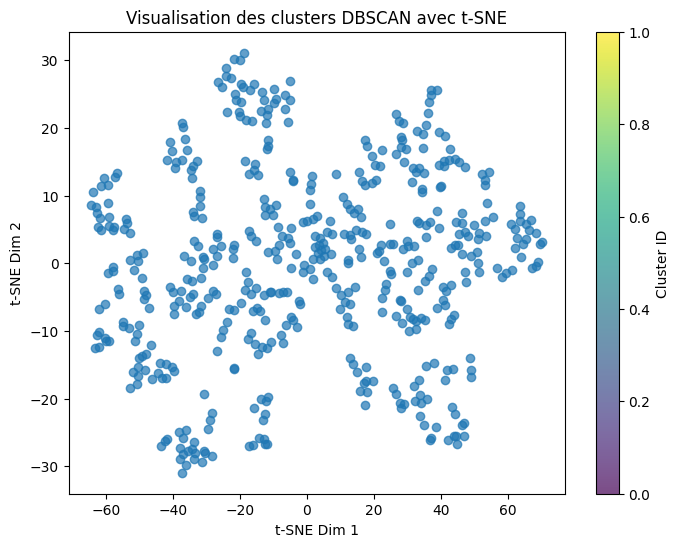

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=8)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\762338312.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)


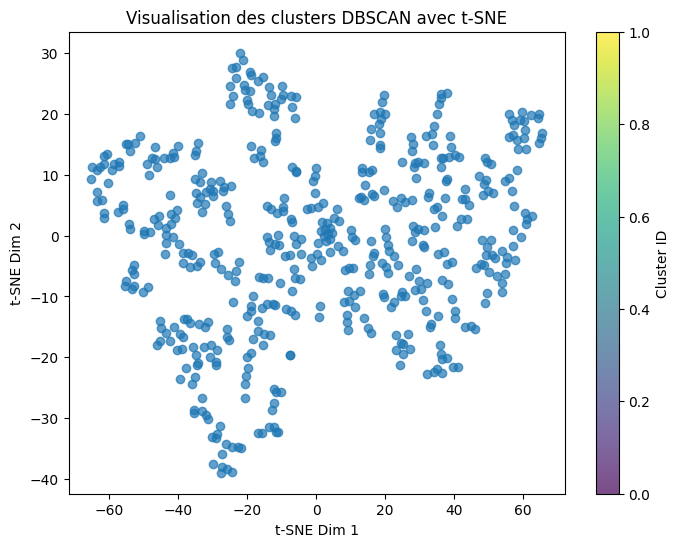

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps pour éviter les écarts trop faibles
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=786)
heatmaps_2d = tsne.fit_transform(heatmaps_scaled)

# Afficher les clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Visualisation des clusters DBSCAN avec t-SNE")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\1780347207.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(heatmaps_3d[:, 0], heatmaps_3d[:, 1], heatmaps_3d[:, 2], cmap="tab10", alpha=0.7)


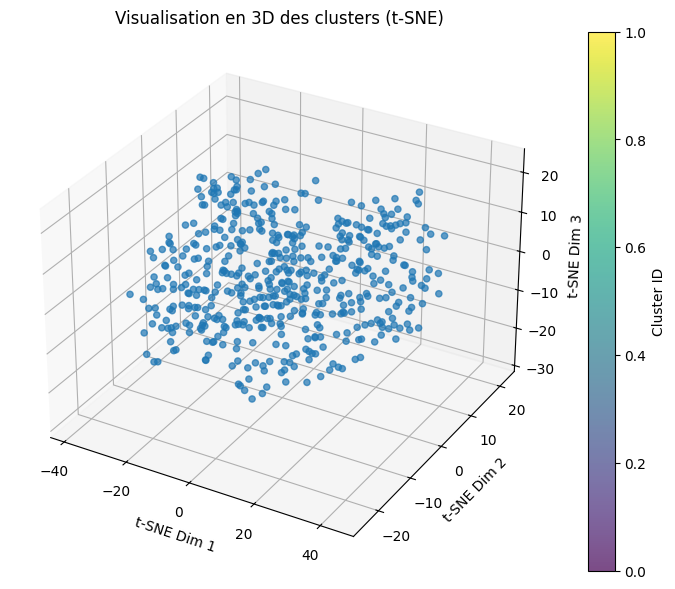

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
heatmaps_3d = tsne_3d.fit_transform(heatmaps_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(heatmaps_3d[:, 0], heatmaps_3d[:, 1], heatmaps_3d[:, 2], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
plt.title("Visualisation en 3D des clusters (t-SNE)")
plt.show()


C:\Users\Guillaume\AppData\Local\Temp\ipykernel_15712\3673342288.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(heatmaps_isomap[:, 0], heatmaps_isomap[:, 1], cmap="tab10", alpha=0.7)


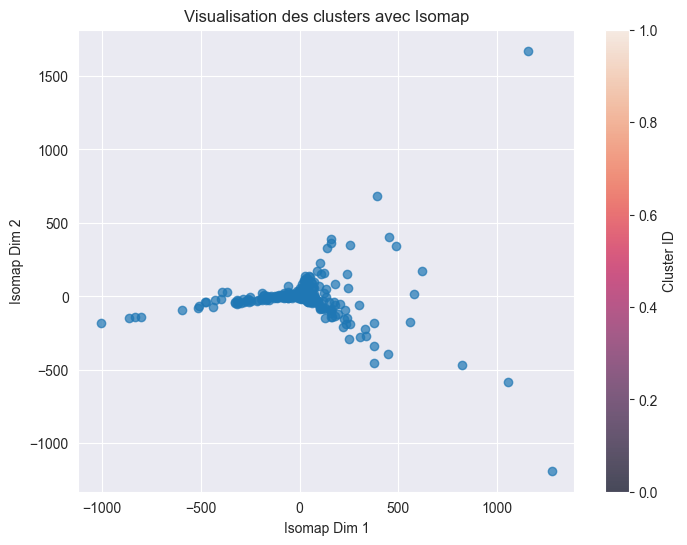

In [19]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=10)
heatmaps_isomap = isomap.fit_transform(heatmaps_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_isomap[:, 0], heatmaps_isomap[:, 1], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("Isomap Dim 1")
plt.ylabel("Isomap Dim 2")
plt.title("Visualisation des clusters avec Isomap")
plt.show()


Nombre de clusters détectés : 6


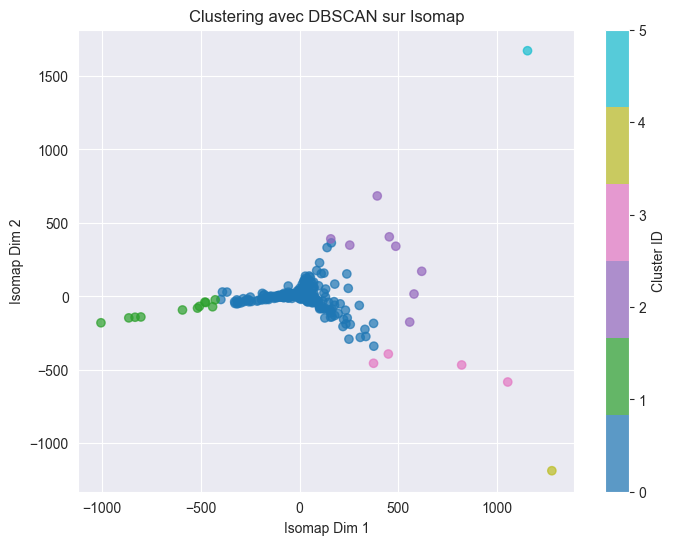

In [32]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hdbscan
from sklearn.cluster import MeanShift

# Appliquer DBSCAN sur les données Isomap
#dbscan = DBSCAN(eps=0.5, min_samples=2)  # Ajuste ces paramètres si besoin
#clusters = dbscan.fit_predict(heatmaps_isomap)
#hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5)
#clusters = hdbscan_cluster.fit_predict(heatmaps_isomap)
mean_shift = MeanShift(bandwidth=300)  # Ajuste la bande passante selon les distances entre tes points
clusters = mean_shift.fit_predict(heatmaps_isomap)
# Nombre de clusters détectés (le bruit est noté -1)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Nombre de clusters détectés : {n_clusters}")

# Définir une colormap adaptée
if n_clusters == 2:
    cmap = ListedColormap(["red", "blue"])  # Deux couleurs très contrastées
else:
    cmap = plt.get_cmap("tab10", n_clusters)  # Couleurs adaptées au nombre de clusters

# Affichage des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_isomap[:, 0], heatmaps_isomap[:, 1], c=clusters, cmap=cmap, alpha=0.7)
plt.colorbar(scatter, label="Cluster ID", ticks=range(min(clusters), max(clusters) + 1))
plt.xlabel("Isomap Dim 1")
plt.ylabel("Isomap Dim 2")
plt.title("Clustering avec DBSCAN sur Isomap")
plt.show()


In [33]:
# Dictionnaire pour stocker les heatmaps de chaque cluster
heatmaps_by_cluster = {}

for cluster in set(clusters):  # Parcours des clusters détectés
    if cluster == -1:
        continue  # Ignorer les points considérés comme bruit

    # Récupérer les indices des éléments appartenant au cluster
    indices = np.where(clusters == cluster)[0]

    # Stocker les heatmaps associés dans un dictionnaire
    heatmaps_by_cluster[cluster] = h1[indices]  # h1 contient les heatmaps bruts

# Vérification : Nombre d'éléments par cluster
for cluster, heatmaps in heatmaps_by_cluster.items():
    print(f"Cluster {cluster} : {heatmaps.shape[0]} éléments")


Cluster 0 : 487 éléments
Cluster 1 : 11 éléments
Cluster 2 : 8 éléments
Cluster 3 : 4 éléments
Cluster 4 : 1 éléments
Cluster 5 : 1 éléments


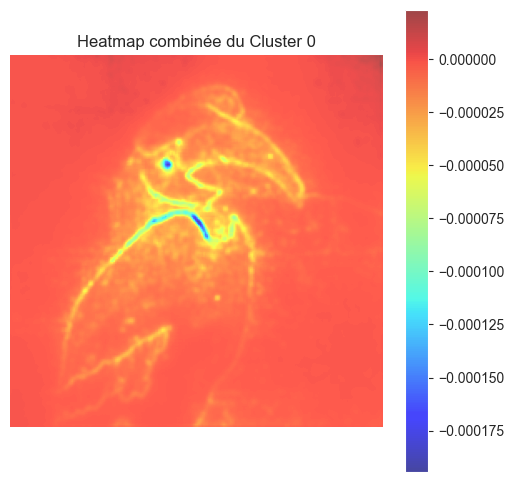

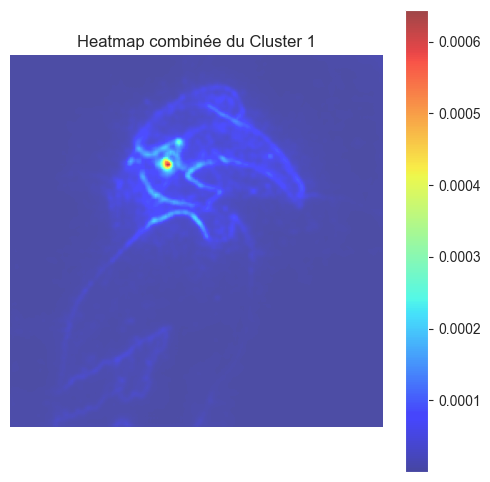

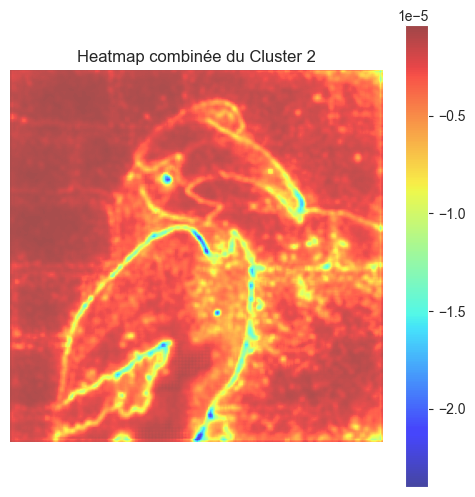

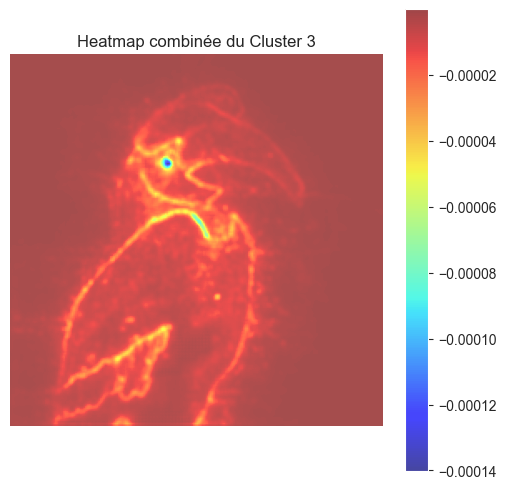

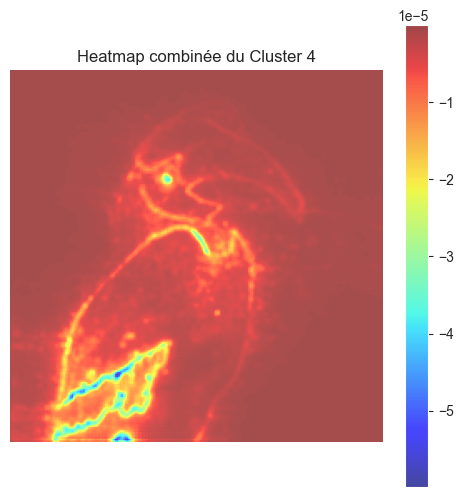

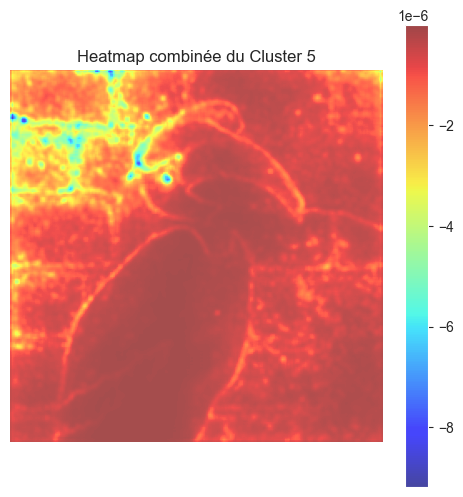

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Création des heatmaps combinées pour chaque cluster
for cluster, heatmaps in heatmaps_by_cluster.items():
    if heatmaps.shape[0] == 0:
        continue  # Sauter si un cluster est vide (peu probable)

    # Somme des heatmaps du cluster pour créer une heatmap combinée
    combined_heatmap = np.sum(heatmaps, axis=0)

    # Affichage
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_heatmap, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.colorbar()
    plt.title(f"Heatmap combinée du Cluster {cluster}")
    plt.show()


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


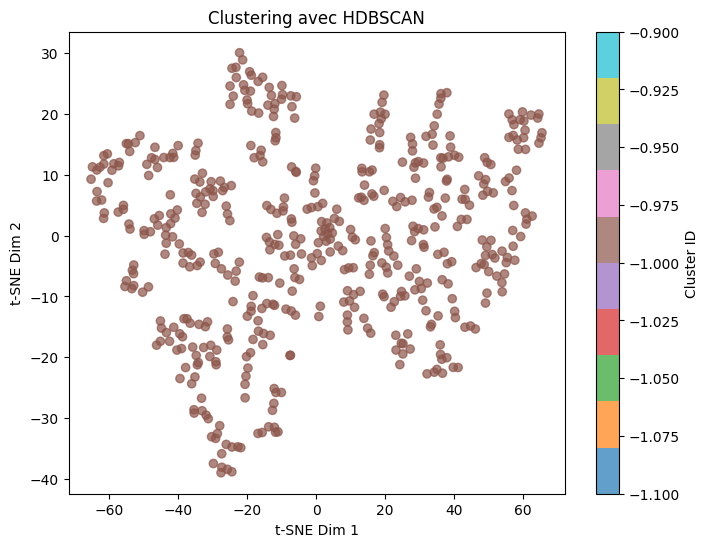

In [43]:
import hdbscan

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5)
hdbscan_labels = hdbscan_cluster.fit_predict(heatmaps_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], c=hdbscan_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Clustering avec HDBSCAN")
plt.show()


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Guillaume\AppData\Local\Temp\ipykernel_7736\7329995.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(umap_3d[:, 0], umap_3d[:, 1], umap_3d[:, 2], cmap="tab10", alpha=0.7)


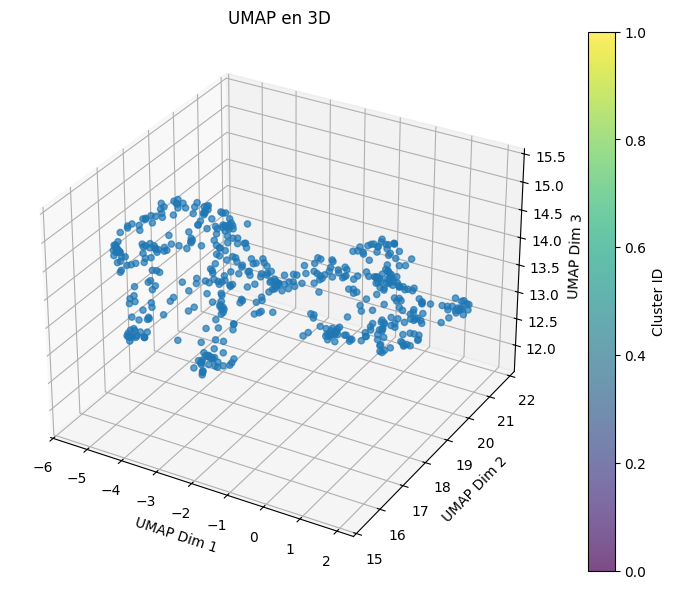

In [44]:
import umap.umap_ as umap

umap_3d = umap.UMAP(n_components=3, n_neighbors=15, random_state=42).fit_transform(heatmaps_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_3d[:, 0], umap_3d[:, 1], umap_3d[:, 2], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
ax.set_xlabel("UMAP Dim 1")
ax.set_ylabel("UMAP Dim 2")
ax.set_zlabel("UMAP Dim 3")
plt.title("UMAP en 3D")
plt.show()


In [ ]:
import seaborn as sns
similarity_matrix = np.corrcoef(heatmaps_scaled)

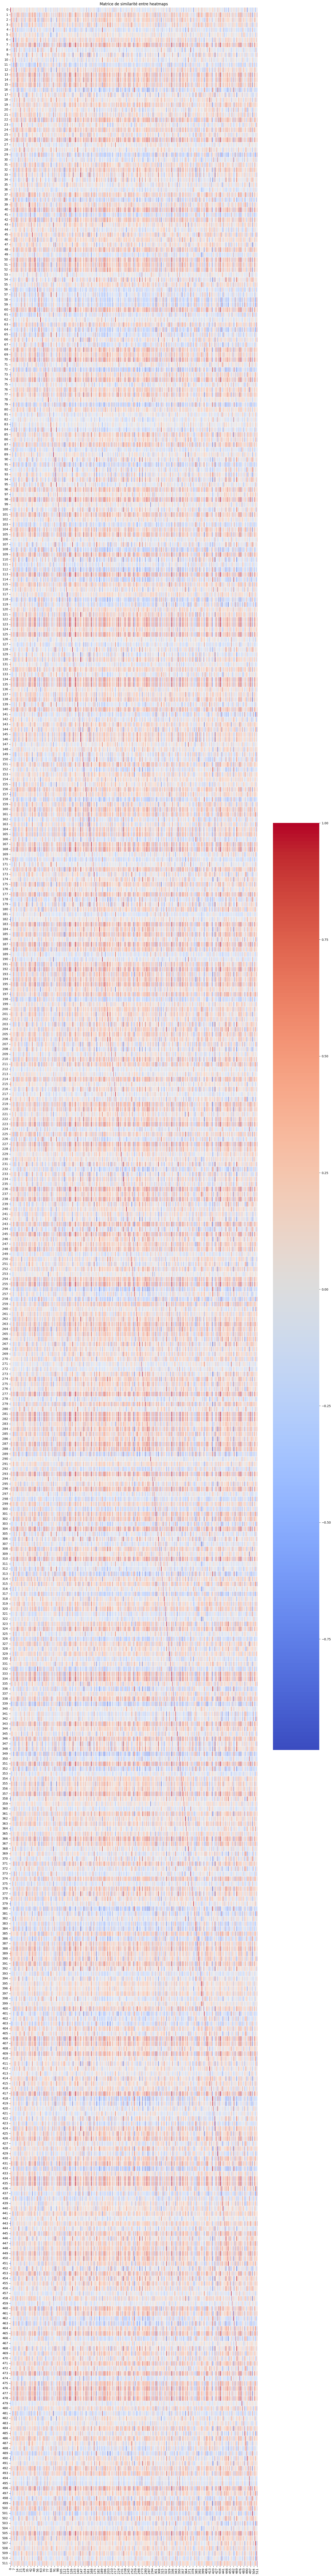

In [47]:

plt.figure(figsize=(18, 150))
sns.heatmap(similarity_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de similarité entre heatmaps")
plt.show()


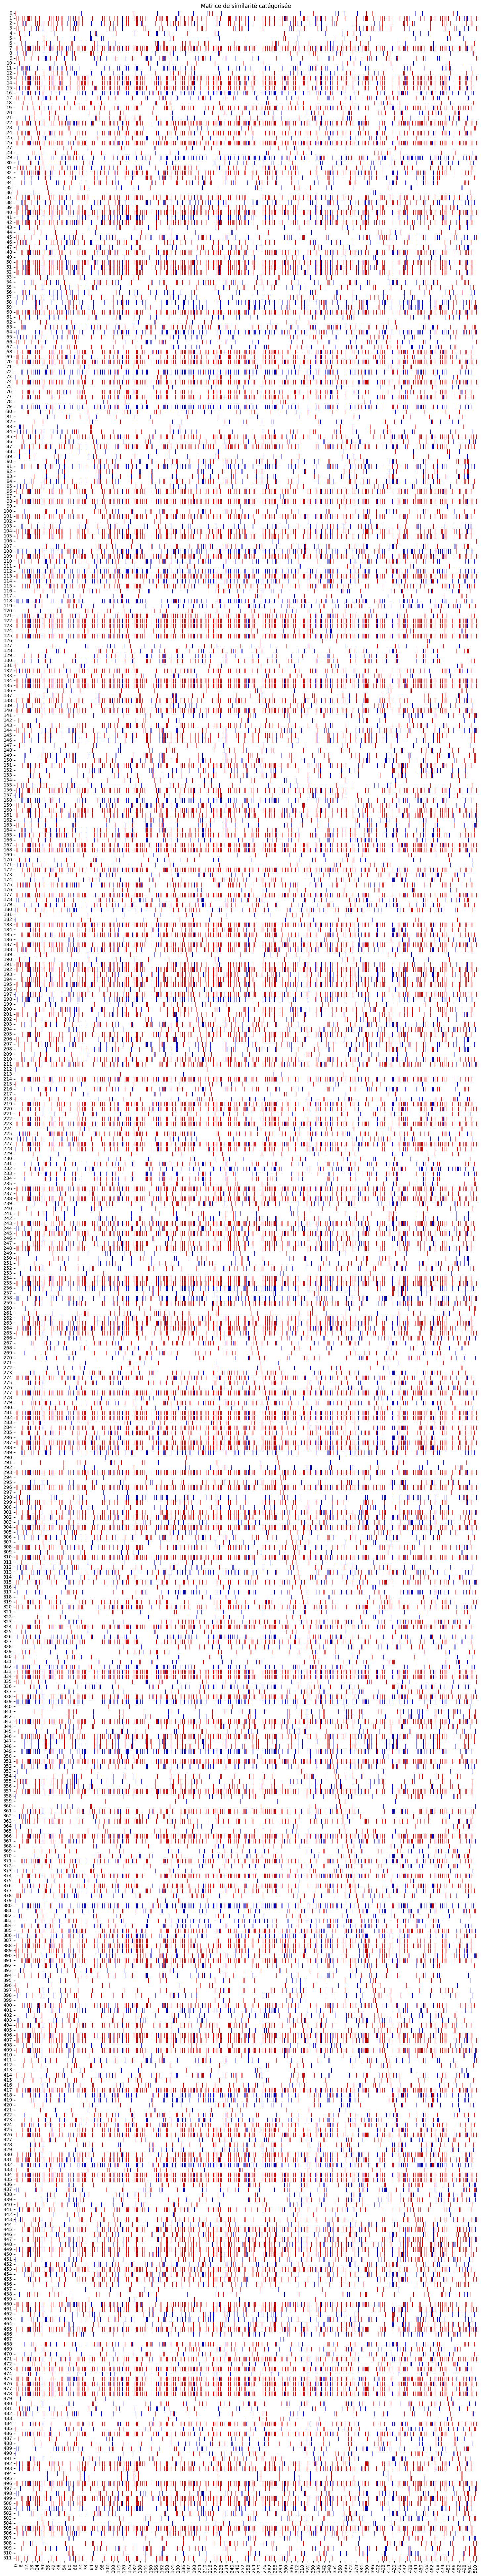

In [50]:
# Création d'une matrice de catégories (-1, 0, 1)
categorized_matrix = np.zeros_like(similarity_matrix)
categorized_matrix[similarity_matrix > 0.5] = 1   # Rouge
categorized_matrix[similarity_matrix < -0.5] = -1  # Bleu

# Définition d'une palette de couleurs personnalisée
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["blue", "white", "red"])  # Bleu < -0.5, Blanc entre -0.5 et 0.5, Rouge > 0.5

# Affichage de la heatmap avec 3 couleurs distinctes
plt.figure(figsize=(18, 100))
sns.heatmap(categorized_matrix, cmap=cmap, linewidths=0.5, annot=False, cbar=False)

plt.title("Matrice de similarité catégorisée")
plt.show()

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


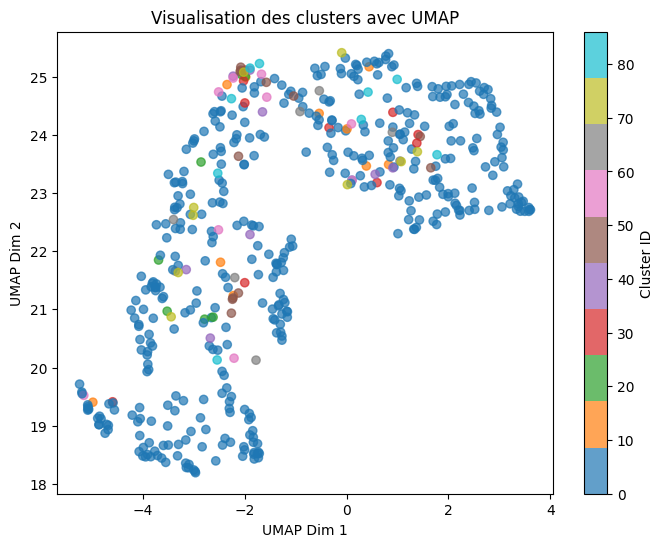

In [39]:
import umap.umap_ as umap

# Réduction de dimension avec UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(heatmaps_scaled)

# Affichage des clusters en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.title("Visualisation des clusters avec UMAP")
plt.show()


In [41]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5)  # Ajuster threshold
clusters = clustering.fit_predict(heatmaps_flat)

print(f"Agglomerative Clustering a trouvé {len(set(clusters))} clusters.")


Agglomerative Clustering a trouvé 1 clusters.


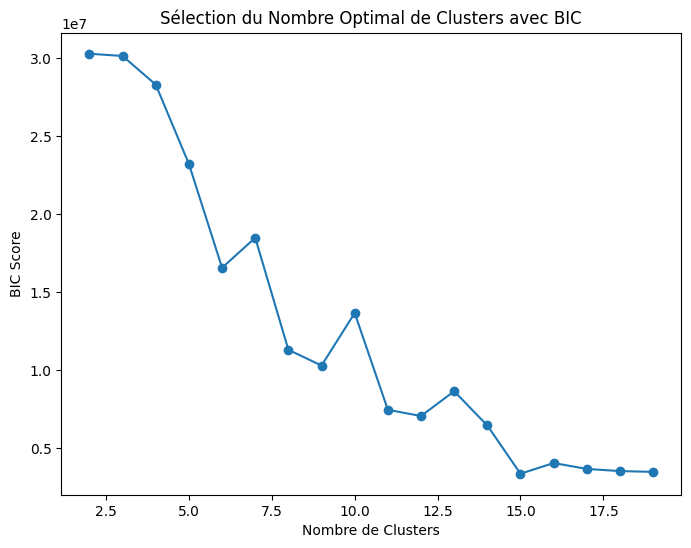

Nombre optimal de clusters selon BIC : 15


In [45]:
bic_scores = []
possible_clusters = range(2, 20)  # Teste entre 2 et 20 clusters

for n in possible_clusters:
    gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=42, reg_covar=1e-3)
    gmm.fit(heatmaps_scaled)
    bic_scores.append(gmm.bic(heatmaps_scaled))

# Tracer le BIC pour voir où il est minimum
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, bic_scores, marker="o")
plt.xlabel("Nombre de Clusters")
plt.ylabel("BIC Score")
plt.title("Sélection du Nombre Optimal de Clusters avec BIC")
plt.show()

# Nombre optimal de clusters
best_n_clusters = possible_clusters[np.argmin(bic_scores)]
print(f"Nombre optimal de clusters selon BIC : {best_n_clusters}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Réduction de dimension avec PCA (2D pour affichage)
pca = PCA(n_components=2)
heatmaps_2d = pca.fit_transform(heatmaps_scaled)

# Appliquer un modèle GMM avec 10 composantes (ajuste si besoin)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(heatmaps_scaled)

# Affichage des clusters GMM
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], c=gmm_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.title("Clustering des Heatmaps avec GMM")
plt.show()


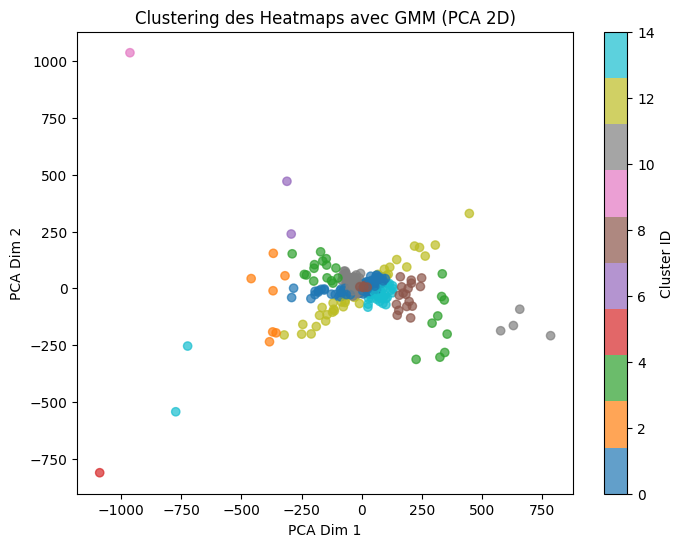

In [46]:
# Normalisation des données
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Réduction de dimension avec PCA
pca = PCA(n_components=2)  # 2D pour affichage
heatmaps_2d = pca.fit_transform(heatmaps_scaled)

# Appliquer GMM sur ces données réduites
gmm = GaussianMixture(n_components=15, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(heatmaps_2d)  # On utilise heatmaps_2d ici !

# Affichage
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], c=gmm_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.title("Clustering des Heatmaps avec GMM (PCA 2D)")
plt.show()


In [47]:
# Normalisation des données
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

# Appliquer GMM sur toutes les dimensions
gmm = GaussianMixture(n_components=15, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(heatmaps_scaled)  # Clustering en haute dimension

# Réduction pour affichage
pca = PCA(n_components=2)
heatmaps_2d = pca.fit_transform(heatmaps_scaled)

# Affichage des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(heatmaps_2d[:, 0], heatmaps_2d[:, 1], c=gmm_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.title("Visualisation des Clusters GMM avec PCA")
plt.show()


MemoryError: Unable to allocate 281. GiB for an array with shape (15, 50176, 50176) and data type float64

In [13]:
from sklearn.preprocessing import StandardScaler

# Normalisation des heatmaps
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)


In [15]:
from sklearn.cluster import DBSCAN

# DBSCAN avec une distance euclidienne
dbscan = DBSCAN(eps=0.5, min_samples=2, metric="euclidean")
labels_dbscan = dbscan.fit_predict(heatmaps_scaled)

print("Clusters DBSCAN:", labels_dbscan)
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")

Clusters DBSCAN: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

In [17]:
import hdbscan

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
labels_hdbscan = clusterer.fit_predict(heatmaps_scaled)

print("Clusters HDBSCAN:", labels_hdbscan)
n_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters HDBSCAN: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 12 -1 -1 -1 -1
 -1 -1 -1 -1 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1  5 -1 -1 -1 -1
 -1 -1 -1 -1 -1  2  1 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1  8 -1  1  9
 -1 -1 13 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 -1
 -1 10 13 13 -1 13 -1 -1  8 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 10 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 13 -1 -1 -1 10 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 13 -1 -1 -1 13 13 -1  6 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 13 -1
 -1  3  5  0 -1 -1 -1 -1 -1 -1 -1

In [18]:
from sklearn.cluster import MeanShift

# Mean Shift
meanshift = MeanShift()
labels_meanshift = meanshift.fit_predict(heatmaps_scaled)

print("Clusters Mean Shift:", labels_meanshift)
n_clusters = len(set(labels_meanshift)) - (1 if -1 in labels_meanshift else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")

Clusters Mean Shift: [ 0  0  0  0 30 59  0  0  0  0  0 52  0  0  0  0 17  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 28 15  0 24  0  0  0 21  0  0  0  0  0
  0  0  0  0  0  0 45  0  0  0 36 51  0  0  0  0 36  0  0  0  0  0  0  0
 12  0  0  0  0  0  0 24  0  0  0  0  8  0  0  0  4 20  0  0  0  0 45  0
  0  0  0  0  0  0 48  0  0  0  0  0 29  0  0  0 22  0 24  0  0  0 39  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 34  0  0
 19  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 15 55  0  0  0  0  0  0  0 42 45  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 54  0  0  0  0 45  0  0  0 15  0  0  0  0  0  0  0  0
 58  0  0  0  0  0  0  0 56  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0
  0  7  0  0  0  0  0  0  0  2  0  0  0 11  0  0 10  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0 14  0
 14 16  0  0  0  0  0  0  0 61  0  0  5  0 46 38  0  0  0  0 21  0  0  0
  0  0  0 27 13 36  0  0 18 43

In [19]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering avec un nombre arbitraire de clusters (ex: 5)
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
labels_spectral = spectral.fit_predict(heatmaps_scaled)

print("Clusters Spectral Clustering:", labels_spectral)
n_clusters = len(set(labels_spectral)) - (1 if -1 in labels_spectral else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")

Clusters Spectral Clustering: [3 2 2 2 0 3 2 3 3 2 3 0 2 3 3 2 4 2 3 3 2 2 3 0 3 2 3 3 3 0 2 2 1 1 1 2 4
 3 4 3 3 2 2 2 3 2 2 2 3 2 3 2 2 3 1 3 3 0 0 0 2 3 2 1 0 0 2 0 3 2 3 3 4 2
 2 2 2 1 1 4 3 3 2 2 0 3 3 1 3 2 1 2 3 2 1 3 3 3 3 3 3 2 3 2 3 3 2 1 0 3 2
 3 4 3 4 3 2 3 0 0 3 1 3 3 2 3 2 2 3 2 1 3 2 3 3 3 3 2 2 0 3 0 2 3 2 1 1 3
 3 1 1 3 2 1 3 2 2 2 2 2 3 2 3 2 1 3 2 3 3 2 0 0 3 3 3 2 3 3 0 1 2 2 2 3 3
 1 2 2 2 2 3 2 3 1 1 2 3 2 0 3 3 2 3 1 2 3 2 2 2 2 1 2 2 3 1 3 1 2 3 3 1 3
 1 3 3 2 0 2 2 3 2 1 2 2 1 1 3 3 3 3 2 4 2 1 1 2 1 3 2 2 2 3 3 2 1 3 4 2 0
 2 3 3 1 3 2 3 2 1 2 1 2 2 3 3 2 3 2 3 4 1 3 3 3 3 3 3 1 3 1 4 2 3 3 3 3 3
 3 3 3 3 2 2 1 0 3 0 1 2 2 2 3 2 3 4 2 2 2 0 2 3 2 0 2 2 1 2 0 2 2 3 0 2 0
 3 3 2 2 2 3 0 2 0 0 2 3 2 1 1 1 4 3 3 4 0 2 2 2 3 2 3 0 3 2 2 3 3 3 2 3 3
 1 1 3 0 2 3 3 1 2 2 4 0 2 2 4 2 0 3 3 2 2 3 1 2 2 3 3 3 0 3 1 2 3 0 3 3 3
 2 2 2 2 2 3 2 2 3 3 3 4 4 2 2 3 2 1 1 3 0 1 2 1 2 4 3 3 2 2 0 0 2 2 2 3 2
 2 2 1 2 2 3 1 2 4 2 1 1 3 2 2 3 2 3 4 4 2 2 0 2 1 2 1 3 3 2 2 2 3 2 3

In [20]:
from sklearn.metrics import silhouette_score

# Vérifier si le clustering est cohérent
silhouette_dbscan = silhouette_score(heatmaps_scaled, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1
silhouette_hdbscan = silhouette_score(heatmaps_scaled, labels_hdbscan) if len(set(labels_hdbscan)) > 1 else -1
silhouette_meanshift = silhouette_score(heatmaps_scaled, labels_meanshift) if len(set(labels_meanshift)) > 1 else -1
silhouette_spectral = silhouette_score(heatmaps_scaled, labels_spectral) if len(set(labels_spectral)) > 1 else -1

print(f"Silhouette Score DBSCAN: {silhouette_dbscan}")
print(f"Silhouette Score HDBSCAN: {silhouette_hdbscan}")
print(f"Silhouette Score Mean Shift: {silhouette_meanshift}")
print(f"Silhouette Score Spectral Clustering: {silhouette_spectral}")


Silhouette Score DBSCAN: -0.49449947476387024
Silhouette Score HDBSCAN: -0.4776330888271332
Silhouette Score Mean Shift: 0.39871013164520264
Silhouette Score Spectral Clustering: 0.028910385444760323
